# Projeto 2 - Ciência dos Dados 

nome: Nicolas Byung Kwan Cho

O objetivo deste projeto é responder a pergunta: Com base nos dados de pluviosidade e temperatura na região de Campinas, como prever o número de casos de dengue?

O dataset escolhido possui informações do número de caos confirmados de dengue na região de Campinas, assim como dados de chuva e temperaturas em determinada data (de 1998 a 2014)

Com o dataset abaixo é fácil ver que nossa variável target apresenta-se na coluna de 'casos confirmados', sendo as outras colunas as features.

### Leitura do dataset

In [662]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [663]:
#leitura do dataset
dados = pd.read_csv('dengue-dataset.csv')

In [664]:
dados.head()

,data,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima
0,1998-01-01,237,179.2,25.7,20.2,28.1
1,1998-02-01,331,226.3,25.1,20.0,28.0
2,1998-03-01,562,149.1,24.8,22.4,27.2
3,1998-04-01,187,46.4,22.7,18.1,26.0
4,1998-05-01,32,88.3,19.2,15.7,22.9


Das colunas acima, chuva é medida em mm e os dados de temperatura em graus celsius

Como em algumas datas não foram relatados os níveis de chuva, as linhas afetadas não participarão da análise, assim como as colunas de data e temperaturas máximas e mínimas que serão consideradas irrelevantes para os casos confirmados. Valores fora da curva também foram desconsiderados (outliers)

In [665]:
limite = 2000
dados_filtrados = dados[(dados["casos-confirmados"] < limite) ]

dados_filtrados.dropna(subset = ['chuva'], inplace=True)
dados_filtrados.drop('data',inplace=True, axis=1) ###
dados_filtrados.drop('temperatura-mininima',inplace=True, axis=1)
dados_filtrados.drop('temperatura-maxima',inplace=True, axis=1)

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [666]:
dados_filtrados.head()

,casos-confirmados,chuva,temperatura-media
0,237,179.2,25.7
1,331,226.3,25.1
2,562,149.1,24.8
3,187,46.4,22.7
4,32,88.3,19.2


## Análise exploratória

Analisando as medidas de cada variavel:

In [667]:
#Para os casos confirmados
print('Medidas a respeito do número de casos confirmados:')
dados_filtrados['casos-confirmados'].describe()

Medidas a respeito do número de casos confirmados:


count     189.000000
mean      115.783069
std       274.971044
min         0.000000
25%         6.000000
50%        17.000000
75%        72.000000
max      1853.000000
Name: casos-confirmados, dtype: float64

In [668]:
#Para os dados da chuva
print('Medidas a respeito da chuva:')
dados_filtrados['chuva'].describe()

Medidas a respeito da chuva:


count    189.000000
mean     117.640741
std       97.824704
min        0.800000
25%       43.100000
50%       86.000000
75%      179.200000
max      452.800000
Name: chuva, dtype: float64

In [669]:
#Para os dados de temperatura
print('Medidas a respeito da temperatura:')
dados_filtrados['temperatura-media'].describe()

Medidas a respeito da temperatura:


count    189.000000
mean      22.277778
std        2.411637
min       16.400000
25%       20.200000
50%       22.800000
75%       24.300000
max       27.200000
Name: temperatura-media, dtype: float64

Devemos então analisar como a variável target se comporta em relação as suas features

#### Casos x Chuva

In [670]:
#COVARIÂNCIA
cov_chuva = dados_filtrados['casos-confirmados'].cov(dados_filtrados['chuva'])
print('Covariância entre número de casos e volume de chuva:', cov_chuva)

Covariância entre número de casos e volume de chuva: -2953.988987391648


In [671]:
#CORRELAÇÃO
corr_chuva = dados_filtrados['casos-confirmados'].corr(dados_filtrados['chuva'])
print('Correlação entre número de casos e volume de chuva:', corr_chuva)

Correlação entre número de casos e volume de chuva: -0.10981795914378017


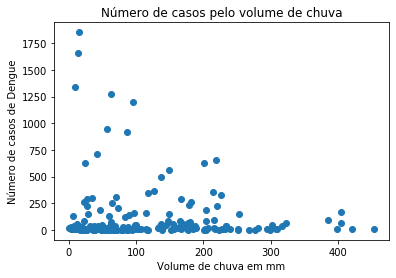

In [672]:
#HISTOGRAMA
plt.scatter(dados_filtrados['chuva'], dados_filtrados['casos-confirmados'])
plt.title('Número de casos pelo volume de chuva')
plt.xlabel('Volume de chuva em mm')
plt.ylabel('Número de casos de Dengue')
plt.show()

Analisando as duas variáveis no tempo

In [673]:
x = []
for i in range(0,len(dados_filtrados['chuva'])):
    x.append(i)

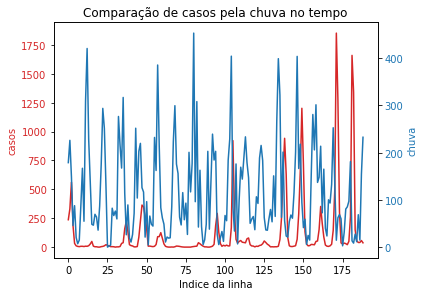

In [674]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Indice da linha')
ax1.set_ylabel('casos', color='tab:red')
ax1.plot(x, dados_filtrados['casos-confirmados'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('chuva', color='tab:blue') 
ax2.plot(x, dados_filtrados['chuva'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.title('Comparação de casos pela chuva no tempo')
plt.show()

Dos dados acima percebe-se que o indice de correlação entre as variáveis é baixo. Mas ao analisar no gráfico, é possível identificar um atraso no número de casos em relação a chuva. Ou seja, após períodos de muita chuva há um intervalo de tempo até que o número de casos aumente. Isso pode ter acontecido, pois o ciclo de reprodução do Aedes aegypti não é instantâneo, levando um tempo até que nascam novos vetores. Além disso, pode-se considerar o tempo detecção da doença que não é imediata. Logo é proposto um 'delay' na variável de casos.

In [675]:
dados_filtrados_delay_casos = dados_filtrados.copy()
dados_filtrados_delay_casos['casos-confirmados'] = dados_filtrados_delay_casos['casos-confirmados'].shift(-2)
dados_filtrados_delay_casos.dropna(subset = ['casos-confirmados'], inplace=True)

In [676]:
#NOVA COVARIANCIA
nova_cov_chuva = dados_filtrados_delay_casos['casos-confirmados'].cov(dados_filtrados_delay_casos['chuva'])
print('Nova covariância entre número de casos e volume de chuva:', nova_cov_chuva)

Nova covariância entre número de casos e volume de chuva: 7424.509024782934


In [677]:
# NOVA CORRELAÇÃO
nova_corr_chuva = dados_filtrados_delay_casos['casos-confirmados'].corr(dados_filtrados_delay_casos['chuva'])
print('Nova correlação entre número de casos e volume de chuva:', nova_corr_chuva)

Nova correlação entre número de casos e volume de chuva: 0.2748022673148059


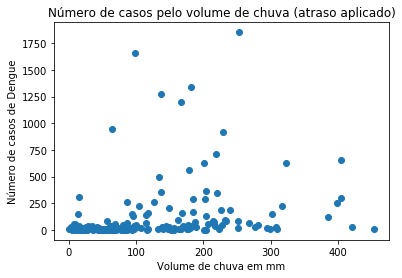

In [678]:
# NOVO HISTOGRAMA
plt.scatter(dados_filtrados_delay_casos['chuva'], dados_filtrados_delay_casos['casos-confirmados'])
plt.title('Número de casos pelo volume de chuva (atraso aplicado)')
plt.xlabel('Volume de chuva em mm')
plt.ylabel('Número de casos de Dengue')
plt.show()

In [679]:
x_delay = []
for i in range(0,len(dados_filtrados_delay_casos['chuva'])):
    x_delay.append(i)

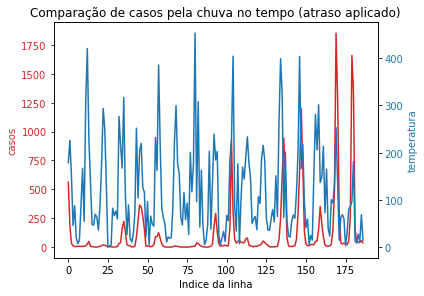

In [680]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Indice da linha')
ax1.set_ylabel('casos', color='tab:red')
ax1.plot(x_delay, dados_filtrados_delay_casos['casos-confirmados'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('temperatura', color='tab:blue')  
ax2.plot(x_delay, dados_filtrados_delay_casos['chuva'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.title('Comparação de casos pela chuva no tempo (atraso aplicado)')
plt.show()

#### Casos x Temperatura

In [681]:
#COVARIANCIA
cov_temp = dados_filtrados['casos-confirmados'].cov(dados_filtrados['temperatura-media'])
print('Covariância entre número de casos e temperatura media:', cov_temp)

Covariância entre número de casos e temperatura media: 62.89781323877069


In [682]:
#CORRELAÇÃO
corr_temp = dados_filtrados['casos-confirmados'].corr(dados_filtrados['temperatura-media'])
print('Correlação entre número de casos e temperatura media:', corr_temp)

Correlação entre número de casos e temperatura media: 0.09484985033586252


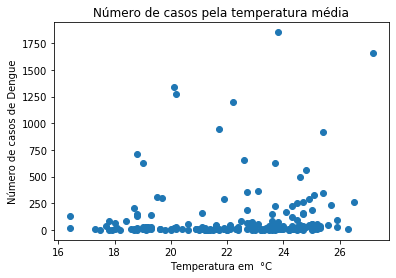

In [683]:
#HISTOGRAMA
plt.scatter(dados_filtrados['temperatura-media'], dados_filtrados['casos-confirmados'])
plt.title('Número de casos pela temperatura média')
plt.xlabel('Temperatura em  °C')
plt.ylabel('Número de casos de Dengue')
plt.show()

Analisando as duas variáveis no tempo

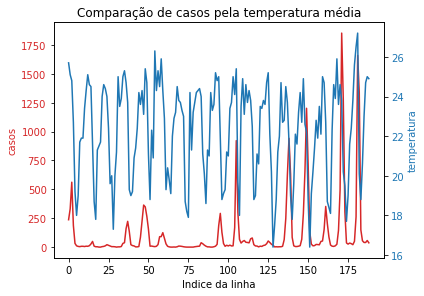

In [684]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Indice da linha')
ax1.set_ylabel('casos', color='tab:red')
ax1.plot(x, dados_filtrados['casos-confirmados'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('temperatura', color='tab:blue')
ax2.plot(x, dados_filtrados['temperatura-media'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.title('Comparação de casos pela temperatura média')
plt.show()

Assim como foi feito com a variável da chuva, o mesmo 'delay' será considerado com a temperatura média

In [685]:
#NOVA COVARIANCIA
nova_cov_temp = dados_filtrados_delay_casos['casos-confirmados'].cov(dados_filtrados_delay_casos['temperatura-media'])
print('Nova covariância entre número de casos e temperatura media:', nova_cov_temp)

Nova covariância entre número de casos e temperatura media: 229.28573975044563


In [686]:
# NOVA CORRELAÇÃO
nova_corr_temp = dados_filtrados_delay_casos['casos-confirmados'].corr(dados_filtrados_delay_casos['temperatura-media'])
print('Nova correlação entre número de casos e temperatura media:', nova_corr_temp)

Nova correlação entre número de casos e temperatura media: 0.34511456009174424


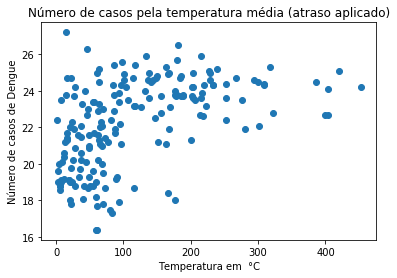

In [687]:
# NOVO HISTOGRAMA
plt.scatter(dados_filtrados_delay_casos['chuva'], dados_filtrados_delay_casos['temperatura-media'])
plt.title('Número de casos pela temperatura média (atraso aplicado)')
plt.xlabel('Temperatura em  °C')
plt.ylabel('Número de casos de Dengue')
plt.show()

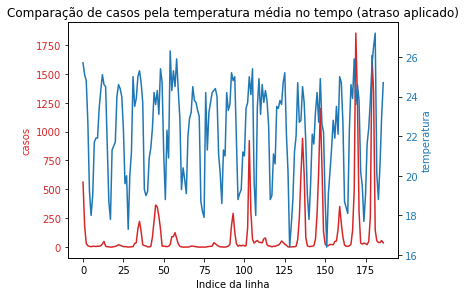

In [688]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Indice da linha')
ax1.set_ylabel('casos', color='tab:red')
ax1.plot(x_delay, dados_filtrados_delay_casos['casos-confirmados'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('temperatura', color='tab:blue')  
ax2.plot(x_delay, dados_filtrados_delay_casos['temperatura-media'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.title('Comparação de casos pela temperatura média no tempo (atraso aplicado)')
plt.show()

### Separando dados de treinamento e teste

Utilizando a biblioteca scikit-learn para serparar entre teste e treino

In [689]:
train, test = train_test_split(dados_filtrados_delay_casos, test_size=0.2)
len(train), len(test)

(149, 38)

In [690]:
train.head()

,casos-confirmados,chuva,temperatura-media
119,37.0,144.4,24.6
178,145.0,93.9,23.9
59,91.0,162.6,25.3
149,5.0,21.9,17.8
66,0.0,22.1,19.8


In [691]:
test.head()

,casos-confirmados,chuva,temperatura-media
192,1342.0,181.4,26.5
179,496.0,133.3,25.9
74,1.0,64.1,23.3
54,6.0,5.3,18.8
167,53.0,206.1,23.5


### Modelo de regressão linear

Analise por meio do statsmodel.OLS

In [692]:
y = train['casos-confirmados']
X = train[['temperatura-media','chuva']]

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      casos-confirmados   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     10.08
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           7.96e-05
Time:                        22:38:02   Log-Likelihood:                -998.47
No. Observations:                 149   AIC:                             2003.
Df Residuals:                     146   BIC:                             2012.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -546.0923    161.711     -3.377      0.001    -865.689    -226.496
temperatura-media    28.2093      7.727      3.651      0.000      12.937      43.481
chuva                 0.0728      0.205      0.356      0.723      -0.332       0.478
==============================================================================
Omnibus:                      180.686   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5350.164
Skew:                           4.728   Prob(JB):                         0.00
Kurtosis:                      30.791   Cond. No.                     1.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Percebe-se que o modelo não está muito bem ajustado para a regressão linear. Utiliza-se a escala logaritmica nas variáveis de forma a melhorar a previsão

In [693]:
#log
train['log_casos-confirmados']=np.log(train['casos-confirmados'])
train['log_temperatura-media']=np.log(train['temperatura-media'])
train['log_chuva']=np.log(train['chuva'])

logx = train['log_chuva']
logy = train['log_casos-confirmados']
logz = train['log_temperatura-media']

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be

In [694]:
#FILTRANDO OS VALORES INFINITOS NOS CASOS CONFIRMADOS EM ESCALA LOG
train = train.replace([np.inf, -np.inf], np.nan)
train.dropna(subset = ['log_casos-confirmados'], inplace=True)

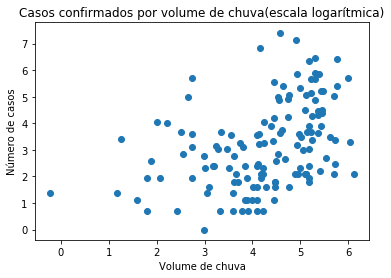

In [695]:
plt.scatter(logx,logy)
plt.title('Casos confirmados por volume de chuva(escala logarítmica)')
plt.xlabel('Volume de chuva')
plt.ylabel('Número de casos')
plt.show()

In [696]:
#CORRELAÇÃO COM A CHUVA EM ESCALA LOGARÍTMICA
log_corr_chuva = train['log_casos-confirmados'].corr(train['log_chuva'])
print('Correlação entre número de casos e volume de chuva em escala logarítmica:', log_corr_chuva)

Correlação entre número de casos e volume de chuva em escala logarítmica: 0.40398509093338003


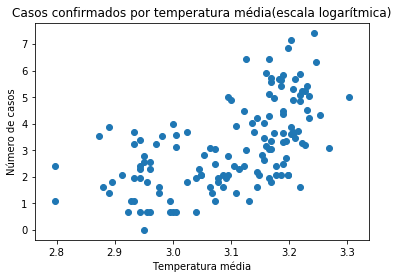

In [697]:
plt.scatter(logz,logy)
plt.title('Casos confirmados por temperatura média(escala logarítmica)')
plt.xlabel('Temperatura média')
plt.ylabel('Número de casos')
plt.show()

In [698]:
#CORRELAÇÃO COM A TEMPERATURA MÉDIA EM ESCALA LOGARÍTMICA
log_corr_temp = train['log_casos-confirmados'].corr(train['log_temperatura-media'])
print('Correlação entre número de casos e temperatura média em escala logarítmica:', log_corr_temp)

Correlação entre número de casos e temperatura média em escala logarítmica: 0.5776377144833877


Assim, uma nova analise das variáveis e parâmetros ficaria:

In [699]:
y = train['log_casos-confirmados']
X = train[['log_temperatura-media','log_chuva']]

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_casos-confirmados   R-squared:                       0.348
Model:                               OLS   Adj. R-squared:                  0.338
Method:                    Least Squares   F-statistic:                     36.01
Date:                   Tue, 17 Nov 2020   Prob (F-statistic):           2.93e-13
Time:                           22:38:02   Log-Likelihood:                -231.63
No. Observations:                    138   AIC:                             469.3
Df Residuals:                        135   BIC:                             478.0
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -19.9732      3.384     -5.903      0.000     -26.665     -13.281
log_temperatura-media     7.2027      1.165      6.183      0.000       4.899       9.506
log_chuva                 0.1949      0.114      1.715      0.089      -0.030       0.420
==============================================================================
Omnibus:                        6.893   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                4.664
Skew:                           0.303   Prob(JB):                       0.0971
Kurtosis:                       2.334   Cond. No.                         174.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A função que realiza a regressão linear múltipla é dada então por:

In [700]:
def regressao_multipla(temperatura, chuva):
    y = -21.8802 + 7.7309*temperatura + 0.2739 * chuva
    return y

### Performance do modelo

In [701]:
def r2(real, previsto, media):    
    num = 0 
    den = 0
    for e,i in zip(real,previsto):
        num += (e-i)**2
        den += (e-media)**2
    coef = 1-(num/den)
    return coef
        
def rms(real, previsto):
    n = len(real)
    somatoria = 0
    for e,i in zip(real,previsto):
        somatoria += (e-i)**2
        i += 1
    erro = ((1/n)*somatoria)**(1/2)
    return erro

#### Testando o modelo para os dados de treino

In [702]:
df_treino = pd.DataFrame (columns = ['casos-confirmados-treino'])
df_treino['casos-confirmados-treino'] = train['log_casos-confirmados']
media_treino = df_treino['casos-confirmados-treino'].mean()    

df_treino['casos-confirmados-previsao'] = train.apply(lambda x: regressao_multipla(x['log_temperatura-media'],x['log_chuva']),axis=1)
df_treino.head()

,casos-confirmados-treino,casos-confirmados-previsao
119,3.610918,4.241904
178,4.976734,3.900854
59,4.510860,4.491331
149,1.609438,1.223984
144,6.439350,3.874208


In [703]:
coef_determinacao = r2(df_treino['casos-confirmados-treino'], df_treino['casos-confirmados-previsao'], media_treino)
raiz_erro_medio = rms(df_treino['casos-confirmados-treino'], df_treino['casos-confirmados-previsao'])
print('DADOS DE TREINO')
print('Coeficiente de determinação(R²): ',coef_determinacao)
print('Raiz do erro médio quadrático(RMS): ',raiz_erro_medio)

DADOS DE TREINO
Coeficiente de determinação(R²):  0.33944616540012706
Raiz do erro médio quadrático(RMS):  1.3046701115423076


#### Testando o modelo para os dados de teste

Primeiro devemos colocar os dados de teste em escala logarítmica, assim como foi feito com os dados de treino

In [704]:
#log
test['log_casos-confirmados']=np.log(test['casos-confirmados'])
test['log_temperatura-media']=np.log(test['temperatura-media'])
test['log_chuva']=np.log(test['chuva'])

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be

In [705]:
#FILTRANDO OS VALORES INFINITOS NOS CASOS CONFIRMADOS EM ESCALA LOG
test = test.replace([np.inf, -np.inf], np.nan)
test.dropna(subset = ['log_casos-confirmados'], inplace=True)

Agora podemos testar o modelo com a base de teste

In [706]:
df_teste = pd.DataFrame (columns = ['casos-confirmados-teste'])
df_teste['casos-confirmados-teste'] = test['log_casos-confirmados']
media_teste = df_teste['casos-confirmados-teste'].mean()    

df_teste['casos-confirmados-previsao'] = test.apply(lambda x: regressao_multipla(x['log_temperatura-media'],x['log_chuva']),axis=1)
df_teste.head()

,casos-confirmados-teste,casos-confirmados-previsao
192,7.201916,4.879551
179,6.206576,4.618111
74,0.000000,3.599724
54,1.791759,1.257939
167,3.970292,3.985693


In [707]:
coef_determinacao_teste = r2(df_teste['casos-confirmados-teste'], df_teste['casos-confirmados-previsao'], media_teste)
raiz_erro_medio_teste = rms(df_teste['casos-confirmados-teste'], df_teste['casos-confirmados-previsao'])
print('DADOS DE TESTE')
print('Coeficiente de determinação(R²): ',coef_determinacao_teste)
print('Raiz do erro médio quadrático(RMS): ',raiz_erro_medio_teste)

DADOS DE TESTE
Coeficiente de determinação(R²):  0.26567354337064053
Raiz do erro médio quadrático(RMS):  1.8266956325694002
